   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.7 MB/s eta 0:00:00
Shape of dataset: (93597, 11)
   work_year experience_level employment_type           job_title  salary  \
0       2025               MI              FT  Research Scientist  208000   
1       2025               MI              FT  Research Scientist  147000   
2       2025               SE              FT  Research Scientist  173000   
3       2025               SE              FT  Research Scientist  117000   
4       2025               MI              FT         AI Engineer  100000   

  salary_currency  salary_in_usd employee_residence  remote_ratio  \
0             USD         208000                 US             0   
1             USD         147000                 US             0   
2             USD         173000                 US             0   
3             USD         117000                 US             0   
4             USD         100000                 US           100   

  company_loca

/tmp/ipython-input-4211464553.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df.reset_index(), x='index', y='R2', palette='viridis')


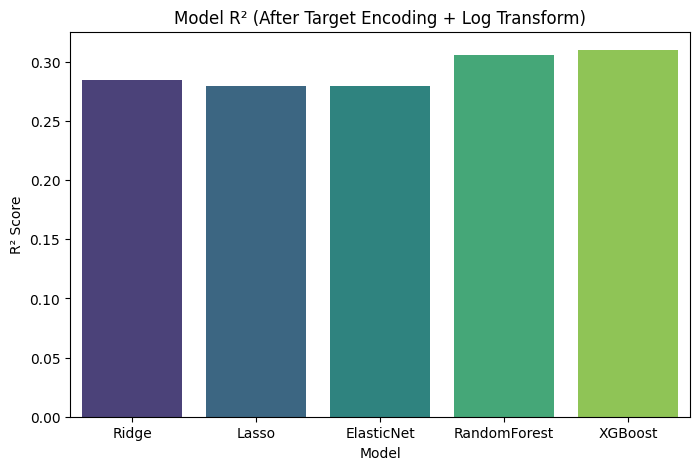

/tmp/ipython-input-4211464553.py:130: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df.reset_index(), x='index', y='RMSE', palette='coolwarm')


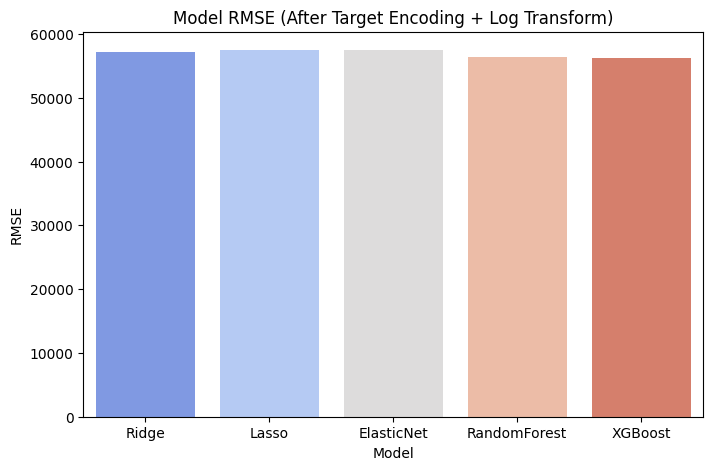


✅ Best performing model (with Target Encoding + Log Transform): XGBoost


In [1]:
# ==========================================================
# 📘 Data Science Salary Prediction (2020–2025)
# Step 3: Target Encoding + Log Transformation (2024 Data)
# ==========================================================

# -----------------------------
# 📦 Import Libraries
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# Target Encoder
!pip install category_encoders -q
import category_encoders as ce

# -----------------------------
# 📂 Load and Inspect Data
# -----------------------------
df = pd.read_csv("DataScience_salaries_2025.csv")

print("Shape of dataset:", df.shape)
print(df.head())
print(df.info())

# -----------------------------
# 🧹 Data Cleaning and Preparation
# -----------------------------
df.rename(columns={
    'work_year': 'year',
    'experience_level': 'seniority_level',
    'employment_type': 'status'
}, inplace=True)

# Convert remote ratio to work setting
df['work_setting'] = df['remote_ratio'].map({
    0: 'On-site',
    50: 'Hybrid',
    100: 'Remote'
})

# Clean categorical columns
for col in ['job_title', 'seniority_level', 'status',
            'employee_residence', 'company_location', 'company_size']:
    df[col] = df[col].astype(str).str.strip().str.title()

# Remove extreme outliers
df = df[df['salary_in_usd'] < 400000]
print("Data after cleaning:", df.shape)

# -----------------------------
# 🎯 Focus on Single Year (2024)
# -----------------------------
df_2024 = df[df['year'] == 2024].copy()
print("Subset for 2024:", df_2024.shape)

# -----------------------------
# 🎯 Define Features and Target
# -----------------------------
X = df_2024[['seniority_level', 'status', 'job_title',
             'company_size', 'work_setting', 'employee_residence']]
y = df_2024['salary_in_usd']

# Log transform target to reduce skew and outlier impact
y_log = np.log1p(y)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
print("Training samples:", X_train.shape[0], "| Test samples:", X_test.shape[0])

# -----------------------------
# 🧩 Step 3 – Target Encoding
# -----------------------------
encoder = ce.TargetEncoder(cols=['seniority_level', 'status', 'job_title',
                                 'company_size', 'work_setting', 'employee_residence'])

X_train_enc = encoder.fit_transform(X_train, y_train)
X_test_enc = encoder.transform(X_test)

# -----------------------------
# 🧮 Train Models (Linear + Non-Linear)
# -----------------------------
models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.001),
    'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.5),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=8, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_enc, y_train)
    y_pred_log = model.predict(X_test_enc)
    y_pred = np.expm1(y_pred_log)   # Convert back to original scale
    y_true = np.expm1(y_test)

    results[name] = {
        'R2': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred))
    }

# -----------------------------
# 📊 Display Model Results
# -----------------------------
results_df = pd.DataFrame(results).T.round(3)
print("\n🔹 Model Results After Target Encoding + Log Transformation:")
print(results_df)

# Bar Plot – Model R²
plt.figure(figsize=(8,5))
sns.barplot(data=results_df.reset_index(), x='index', y='R2', palette='viridis')
plt.title('Model R² (After Target Encoding + Log Transform)')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.show()

# Bar Plot – RMSE
plt.figure(figsize=(8,5))
sns.barplot(data=results_df.reset_index(), x='index', y='RMSE', palette='coolwarm')
plt.title('Model RMSE (After Target Encoding + Log Transform)')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()

# -----------------------------
# 🧾 Summary
# -----------------------------
best_model = results_df['R2'].idxmax()
print(f"\n✅ Best performing model (with Target Encoding + Log Transform): {best_model}")
